## SYMA : RecSys Challenge 2022

Authors:

- Victor Simonin
- Alexandre Lemonnier
- Sarah Gutierez
- Alexandre Poignant

In [273]:
import csv
import numpy as np
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras import callbacks
from keras import layers
from keras import models
from keras import Sequential
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

np.random.seed = 42
warnings.filterwarnings("ignore")

# Loading data

`candidate_items.csv`: contains all the items available

In [274]:
candidates = pd.read_csv('./data/candidate_items.csv')
candidates

item_id
0           4
1           8
2           9
3          19
4          20
...       ...
4985    28128
4986    28131
4987    28132
4988    28133
4989    28137

[4990 rows x 1 columns]

`item_features.csv`: contains all the features of each item

In [275]:
items = pd.read_csv('./data/item_features.csv')
items

item_id  feature_category_id  feature_value_id
0             2                   56               365
1             2                   62               801
2             2                   68               351
3             2                   33               802
4             2                   72                75
...         ...                  ...               ...
471746    28143                   68               351
471747    28143                   55               390
471748    28143                   11               109
471749    28143                   73                91
471750    28143                   47               549

[471751 rows x 3 columns]

`train_purchases.csv`: contains all the purchases that occurred at the end of a session.

In [276]:
train_purchases = pd.read_csv('data/train_purchases.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
train_purchases

session_id  item_id                     date
0                3    15085  2020-12-18 21:26:47.986
1               13    18626  2020-03-13 19:36:15.507
2               18    24911  2020-08-26 19:20:32.049
3               19    12534   2020-11-02 17:16:45.92
4               24    13226  2020-02-26 18:27:44.114
...            ...      ...                      ...
999995     4439986     2915  2021-05-13 11:56:37.464
999996     4439990     8786  2020-08-22 14:28:22.382
999997     4439994    21630  2020-11-27 20:10:28.961
999998     4439999    16962  2020-11-27 11:01:41.356
999999     4440001    16631  2020-10-30 23:46:05.218

[1000000 rows x 3 columns]

`train_sessions.csv`: contains all the items viewed in a session for each session_id

In [277]:
train_sessions = pd.read_csv('data/train_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
train_sessions

session_id  item_id                     date
0                 3     9655  2020-12-18 21:25:00.373
1                 3     9655  2020-12-18 21:19:48.093
2                13    15654  2020-03-13 19:35:27.136
3                18    18316  2020-08-26 19:18:30.833
4                18     2507  2020-08-26 19:16:31.211
...             ...      ...                      ...
4743815     4440001    20409  2020-10-30 23:37:20.658
4743816     4440001    14155  2020-10-30 23:31:56.607
4743817     4440001    14303  2020-10-30 23:36:17.934
4743818     4440001    27852  2020-10-30 23:39:55.186
4743819     4440001      305  2020-10-30 23:27:37.873

[4743820 rows x 3 columns]

`test_leaderboard_sessions`: contains the input sessions for the leader-board

In [278]:
test_leaderboard_sessions = pd.read_csv('./data/test_leaderboard_sessions.csv', dtype={'session_id': int, 'item_id': int, 'date':object})
test_leaderboard_sessions

session_id  item_id                     date
0               26    19185  2021-06-16 09:53:54.158
1              200    17089  2021-06-25 12:23:40.811
2              200    17089  2021-06-25 12:24:36.631
3              200     8060  2021-06-25 12:24:41.677
4              200     4758  2021-06-25 12:24:50.692
...            ...      ...                      ...
229349     4439653    25955   2021-06-11 10:22:57.47
229350     4439653    12179  2021-06-11 10:23:00.663
229351     4439757     2078  2021-06-30 11:42:15.073
229352     4439757     2078  2021-06-30 11:43:13.725
229353     4439757     6790  2021-06-30 11:44:52.704

[229354 rows x 3 columns]

# Data analysis

Items are represented in a sparse format with the id of the feature and its value. We have no information on whether or not it is categorical or numerical, or the number of features.  
We want to explore them a little bit and find a compact representation.

First we want to know the coverage of each feature:

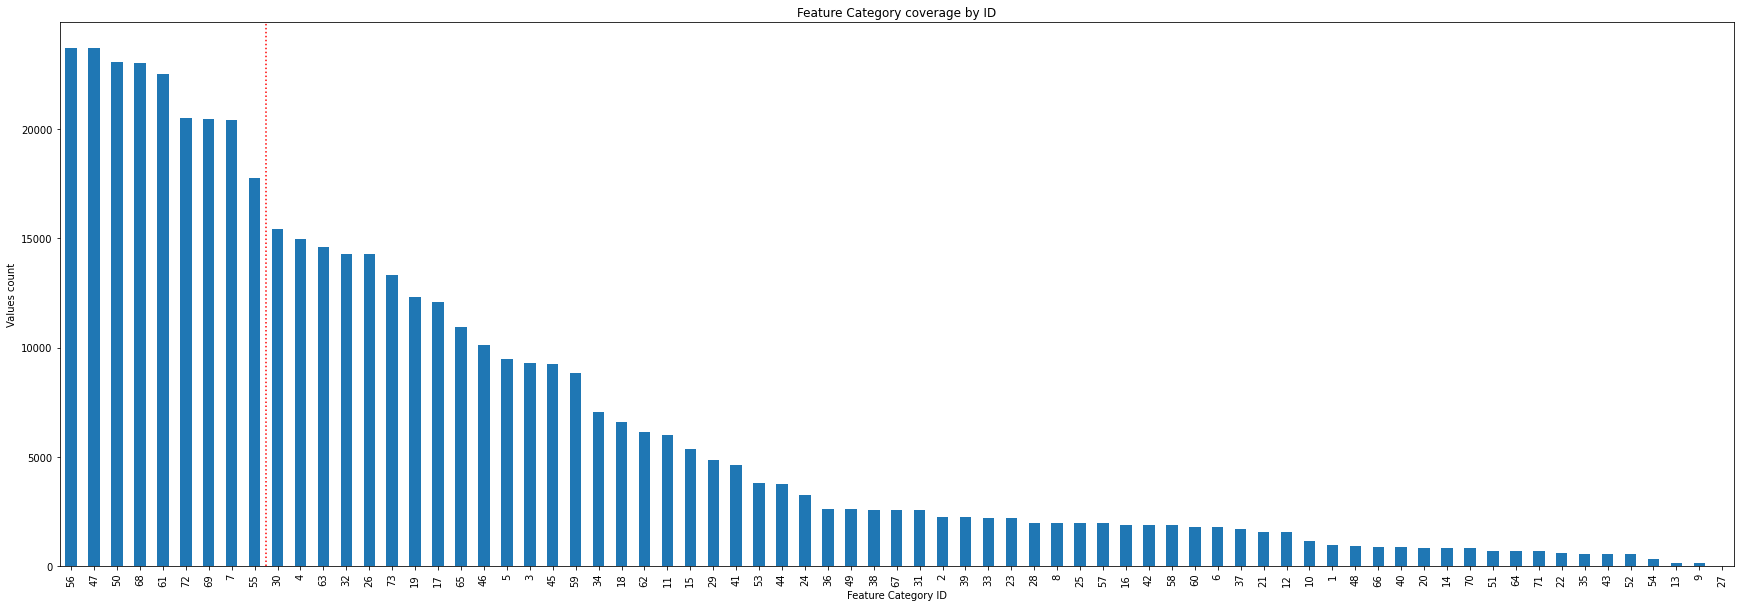

In [279]:
coverage = items['feature_category_id'].sort_values(ascending=False).value_counts(sort=True)
coverage.plot(
    kind='bar',
    figsize=(30, 10), 
    xlabel='Feature Category ID',
    ylabel='Values count',
    title='Feature Category coverage by ID')
plt.axvline(x = 8.5, color='r', linestyle='dotted')

We will only work with the 8 most represented features for our recommmendation systems algorithms.

73 features is not that much, let's see how each of them look. Let's display the counts / min / max / std for each feature. 

In [280]:
items.drop(columns='item_id').groupby('feature_category_id', sort=False).describe()

feature_value_id                                        \
                               count        mean         std    min    25%   
feature_category_id                                                          
56                           23691.0  360.189861  107.438375    1.0  365.0   
62                            6148.0  639.005856  318.478435   15.0  801.0   
68                           23038.0  443.496050  230.800434   10.0  351.0   
33                            2221.0  328.501126  364.058791   36.0   36.0   
72                           20499.0  191.034392  218.286790    7.0   75.0   
...                              ...         ...         ...    ...    ...   
66                             877.0  869.124287   72.171785  264.0  886.0   
40                             877.0  594.037628  204.118748   49.0  449.0   
9                              137.0  223.635036   77.537171  175.0  175.0   
13                             137.0  580.554745  206.876701  252.0  252.0   
27                               1.0  423.000000         NaN  423.0  423.0   

                                          
                       50%    75%    max  
feature_category_id                       
56                   365.0  365.0  868.0  
62                   801.0  801.0  896.0  
68                   373.0  702.0  903.0  
33                    36.0  764.0  873.0  
72                    75.0  263.0  883.0  
...                    ...    ...    ...  
66                   886.0  886.0  886.0  
40                   717.0  717.0  717.0  
9                    190.0  190.0  369.0  
13                   698.0  698.0  905.0  
27                   423.0  423.0  423.0  

[73 rows x 8 columns]

We can see that the feature 27 is useless, because it has all the time the same value, we decided to remove it:

In [281]:
items.drop(items[items['feature_category_id'] == 27].index, inplace=True)
items

item_id  feature_category_id  feature_value_id
0             2                   56               365
1             2                   62               801
2             2                   68               351
3             2                   33               802
4             2                   72                75
...         ...                  ...               ...
471746    28143                   68               351
471747    28143                   55               390
471748    28143                   11               109
471749    28143                   73                91
471750    28143                   47               549

[471750 rows x 3 columns]

Let's see how the sessions are represented in the `train_sessions` dataset:

<AxesSubplot:title={'center':"Count of sessions' ID per range"}, xlabel="Ranges of sessions' ID", ylabel="Sessions' ID count">

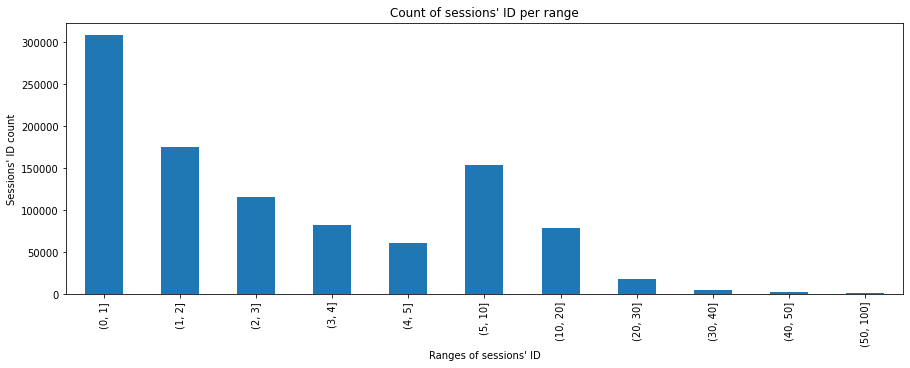

In [282]:
pd.cut(list(train_sessions['session_id'].value_counts()),
       bins=[0,1,2,3,4,5,10,20,30,40,50,100]).value_counts().plot(kind='bar',
                                                                      figsize=(15, 5), 
                                                                      xlabel='Ranges of sessions\' ID',
                                                                      ylabel='Sessions\' ID count',
                                                                      title='Count of sessions\' ID per range')

We can see that most of the `train_sessions` dataset represent the session 0 and 1.

# Embeddings items

If 73 features is not a lot, it is still a big number given the number of samples for your poor laptop if you make it dense. It is also good practice to preprocess the data into a set of embeddings without sparse format because most ML algorithm do not handle sparse. We want to do it now. Use TruncatedSVD from scikit-learn with n_components = 12 (or less depending on your memory) and compute embeddings for your items.

In [283]:
matrix = sparse.coo_matrix((items["feature_value_id"], (items["item_id"], items["feature_category_id"])))
matrix

<28144x74 sparse matrix of type '<class 'numpy.int64'>'
	with 471750 stored elements in COOrdinate format>

In [284]:
svd = TruncatedSVD(n_components=12)
embeddings_items = pd.DataFrame(svd.fit_transform(matrix))
embeddings_items.shape

(28144, 12)

You now have a matrix of dimension (28144, n_components) representing the items.

In [285]:
embeddings_items

0           1            2           3            4   \
0         0.000000    0.000000     0.000000    0.000000     0.000000   
1         0.000000    0.000000     0.000000    0.000000     0.000000   
2       794.680184  377.343647  -303.561668  669.612842   487.114368   
3      2387.218101 -924.921010   161.342833 -448.550085   -36.610415   
4      2304.639154 -837.402436   194.342676 -143.934261  -183.789478   
...            ...         ...          ...         ...          ...   
28139  2496.719059 -681.709967   127.865500   94.363970  -141.323316   
28140   747.063373  532.023457 -1458.557352 -589.887937  -396.119323   
28141  2039.201872 -664.322600    27.056808 -712.698186    16.570608   
28142  1472.569195  356.499020  -347.940108   38.524905   879.686439   
28143  1416.456714  285.630601  -353.123128 -233.109338  1079.421747   

               5           6           7           8           9           10  \
0        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1        0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
2       31.141596  179.078793  296.626964 -152.269779 -449.920838  -81.814739   
3     -508.700457 -261.128901  140.368007 -136.175160  -87.197007  102.493333   
4        3.300821  190.625128 -170.912461 -156.886121  -63.897454 -371.864742   
...           ...         ...         ...         ...         ...         ...   
28139  830.502321 -244.846300  -96.473214  366.870133   38.879578 -407.594529   
28140    6.417455   44.155236  -82.015157 -223.804063 -182.538483   80.207662   
28141   17.025626  252.171984 -164.653479  -58.411650 -298.389715  -74.369037   
28142  493.900700   56.272202   12.574828  226.657854  -34.781702 -237.678911   
28143   34.144187 -404.365324  -79.709580 -131.854500  201.329522  -32.679401   

               11  
0        0.000000  
1        0.000000  
2       40.926965  
3     -520.683317  
4       52.202817  
...           ...  
28139  -29.073147  
28140  -74.648583  
28141 -138.189957  
28142 -299.884277  
28143  374.676164  

[28144 rows x 12 columns]

We need to remove some object otherwise we could be out of memory.

In [286]:
del items
del matrix
del svd

# Embedding sessions

Sessions are defined by a series of items, we first want to see what they look like to be able to find a suitable representation for them.

We start by sampling the train_sessions dataframe to keep 10% of the data.

In [287]:
sample_size = len(train_sessions) * 0.1
sample = train_sessions.sample(int(sample_size))
sample

session_id  item_id                     date
12589         11622     3639  2020-08-22 11:58:43.719
3474389     3249096       89  2020-05-11 10:40:07.758
2419186     2258653    19607  2020-11-29 19:40:35.606
4263459     3989469    10017  2020-04-18 13:59:29.524
1886602     1763309    21223   2020-11-29 15:28:28.26
...             ...      ...                      ...
3842978     3594123     4066  2020-06-28 20:40:18.825
2836496     2650859     2855  2020-11-27 21:58:00.553
3423097     3201195     1786  2020-06-29 16:09:55.123
4203974     3934276     2173   2021-02-18 18:05:39.17
2604906     2432094     7969  2021-05-23 09:23:58.884

[474382 rows x 3 columns]

Let's rank our `session_id` with their count of relative items:

In [288]:
sessions_ranks = sample.groupby('session_id').agg(rank=('item_id', 'count'))
sessions_ranks['session_id'] = sessions_ranks.index
sessions_ranks

rank  session_id
session_id                  
31             2          31
36             1          36
77             1          77
108            6         108
113            1         113
...          ...         ...
4439964        1     4439964
4439973        1     4439973
4439986        2     4439986
4439990        1     4439990
4440001        3     4440001

[318106 rows x 2 columns]

In [289]:
sample = sample.join(sessions_ranks, on='session_id', rsuffix='_outer')
sample

session_id  item_id                     date  rank  session_id_outer
12589         11622     3639  2020-08-22 11:58:43.719     1             11622
3474389     3249096       89  2020-05-11 10:40:07.758     1           3249096
2419186     2258653    19607  2020-11-29 19:40:35.606     1           2258653
4263459     3989469    10017  2020-04-18 13:59:29.524     4           3989469
1886602     1763309    21223   2020-11-29 15:28:28.26     1           1763309
...             ...      ...                      ...   ...               ...
3842978     3594123     4066  2020-06-28 20:40:18.825     1           3594123
2836496     2650859     2855  2020-11-27 21:58:00.553     1           2650859
3423097     3201195     1786  2020-06-29 16:09:55.123     2           3201195
4203974     3934276     2173   2021-02-18 18:05:39.17     1           3934276
2604906     2432094     7969  2021-05-23 09:23:58.884     5           2432094

[474382 rows x 5 columns]

After the join, we have two times the information of session_id, we remove the last one:

In [290]:
sample.drop('session_id_outer', inplace=True, axis=1)
sample

session_id  item_id                     date  rank
12589         11622     3639  2020-08-22 11:58:43.719     1
3474389     3249096       89  2020-05-11 10:40:07.758     1
2419186     2258653    19607  2020-11-29 19:40:35.606     1
4263459     3989469    10017  2020-04-18 13:59:29.524     4
1886602     1763309    21223   2020-11-29 15:28:28.26     1
...             ...      ...                      ...   ...
3842978     3594123     4066  2020-06-28 20:40:18.825     1
2836496     2650859     2855  2020-11-27 21:58:00.553     1
3423097     3201195     1786  2020-06-29 16:09:55.123     2
4203974     3934276     2173   2021-02-18 18:05:39.17     1
2604906     2432094     7969  2021-05-23 09:23:58.884     5

[474382 rows x 4 columns]

We determine a threshold to contain completely 90% of the sessions. This is how we will compute the session representation.

Let $k$ be the length we picked for our session. We vectorize our sessions by either concatenating the embedding of the corresponding items, or averaging them (if memory is scarse).

In [291]:
k = 4
sample = sample[sample['rank'] < k]
sample

session_id  item_id                     date  rank
12589         11622     3639  2020-08-22 11:58:43.719     1
3474389     3249096       89  2020-05-11 10:40:07.758     1
2419186     2258653    19607  2020-11-29 19:40:35.606     1
1886602     1763309    21223   2020-11-29 15:28:28.26     1
588422       550453    13617  2020-07-01 19:16:50.838     1
...             ...      ...                      ...   ...
2708154     2527975    10448   2020-03-24 18:18:36.73     1
3842978     3594123     4066  2020-06-28 20:40:18.825     1
2836496     2650859     2855  2020-11-27 21:58:00.553     1
3423097     3201195     1786  2020-06-29 16:09:55.123     2
4203974     3934276     2173   2021-02-18 18:05:39.17     1

[403978 rows x 4 columns]

In [292]:
def get_x_feature(serie, n):
    return serie.iloc[n] if len(serie) > n else 0.

In [293]:
sample = sample.drop(['date', 'rank'], axis=1) \
               .join(embeddings_items, on='item_id', rsuffix='_outer') \
               .set_index('session_id')
sample

item_id            0            1            2            3  \
session_id                                                                
11622          3639   883.898154   755.330279 -1618.352923  -655.997316   
3249096          89  1772.758445   595.177719   -11.665127  -458.619829   
2258653       19607  2249.689089  -721.590555   107.243458  -567.063636   
1763309       21223  1514.226384   172.436680  -503.011603  1208.657281   
550453        13617  2162.366820  1692.858472   454.101612   792.199642   
...             ...          ...          ...          ...          ...   
2527975       10448  2735.115221  1310.577078  1281.952891  -392.855976   
3594123        4066  2426.124931  -699.533938   150.860128    61.916438   
2650859        2855  2416.224985   220.202006   118.665190  -669.128173   
3201195        1786   829.292392   843.887889 -1955.357461  -908.678229   
3934276        2173  2110.649809  -781.320548   199.221507  -309.559558   

                      4           5            6           7           8  \
session_id                                                                 
11622       -230.451869  113.829069   -54.891329  102.022810  266.582320   
3249096     1152.565886 -139.305454  -458.928920   84.374072   96.689976   
2258653      190.482731   31.912906   -82.769405   83.588903  -87.717572   
1763309       60.053149 -210.651350   274.356700 -105.606372  -80.937189   
550453      -707.923028 -137.177181  -216.382855  246.288846  197.703295   
...                 ...         ...          ...         ...         ...   
2527975    -1222.180683 -362.816774   579.784338  342.557105  295.892068   
3594123     -204.411237  840.909125  -133.653847 -143.566976  386.647373   
2650859     -149.760991  -77.059523   969.135421  238.637511  113.898632   
3201195     -441.001838   55.932100  -102.684911   16.677227  232.313165   
3934276     -331.151017 -225.669531  1058.132472  185.642323   51.180213   

                     9          10          11  
session_id                                      
11622       136.296628  -87.570490  112.196866  
3249096     -21.463454 -308.287234  -74.780541  
2258653    -410.599490  -94.812162  -14.327590  
1763309    -580.908958  249.393419   35.397137  
550453      -52.766425    1.230929   -0.685819  
...                ...         ...         ...  
2527975     176.208075 -274.551627  362.347868  
3594123      -7.501031 -441.615936    0.224086  
2650859     365.722181 -147.664120   42.436629  
3201195     250.826199 -173.999877  -23.008640  
3934276       5.130452   64.582990   22.695808  

[403978 rows x 13 columns]

In [294]:
columns = { f'<lambda_{i}>': i + 1 for i in range(10) }

In [305]:
sample = sample.groupby('session_id')[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11].agg([
    lambda x: x.iloc[0] if len(x) > 0 else 0.,
    lambda x: x.iloc[1] if len(x) > 1 else 0.,
]).rename(columns=columns)

sample.columns = sample.columns.to_flat_index()
sample

KeyError: 'Columns not found: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11'

In [306]:
del session_infos, plot_session

NameError: name 'session_infos' is not defined

# Embedding purchases
Purchases are one item, so we simply use their embedding. However, we also need to add negative samples so that our model not only learn on positives (One class SVM can do this, but those models are not known to generalize well...). In order to generate negative samples, we shuffle the item_id columns of 4 copies of the purchase array. The original values have a label 1, the copies that have been shuffled have a value of 0.

In [300]:
negative_purchases = pd.concat([train_purchases.copy() for _ in range(4)]).sample(frac=1).reset_index(drop=True)
negative_purchases['item_id'] = np.random.permutation(negative_purchases['item_id'])
negative_purchases['y'] = 0

embedding_purchases = train_purchases.copy()
embedding_purchases['y'] = 1

embedding_purchases = pd.concat([embedding_purchases, negative_purchases]).drop('date', axis=1).reset_index(drop=True)
embedding_purchases = embeddings_items.merge(embedding_purchases, right_on='item_id', left_index=True).drop('item_id', axis=1)
embedding_purchases

0           1           2           3            4  \
38061    2387.218101 -924.921010  161.342833 -448.550085   -36.610415   
41931    2387.218101 -924.921010  161.342833 -448.550085   -36.610415   
89368    2387.218101 -924.921010  161.342833 -448.550085   -36.610415   
181165   2387.218101 -924.921010  161.342833 -448.550085   -36.610415   
213634   2387.218101 -924.921010  161.342833 -448.550085   -36.610415   
...              ...         ...         ...         ...          ...   
3085247  1416.456714  285.630601 -353.123128 -233.109338  1079.421747   
3784625  1416.456714  285.630601 -353.123128 -233.109338  1079.421747   
4439364  1416.456714  285.630601 -353.123128 -233.109338  1079.421747   
4567262  1416.456714  285.630601 -353.123128 -233.109338  1079.421747   
4840537  1416.456714  285.630601 -353.123128 -233.109338  1079.421747   

                  5           6           7          8           9  \
38061   -508.700457 -261.128901  140.368007 -136.17516  -87.197007   
41931   -508.700457 -261.128901  140.368007 -136.17516  -87.197007   
89368   -508.700457 -261.128901  140.368007 -136.17516  -87.197007   
181165  -508.700457 -261.128901  140.368007 -136.17516  -87.197007   
213634  -508.700457 -261.128901  140.368007 -136.17516  -87.197007   
...             ...         ...         ...        ...         ...   
3085247   34.144187 -404.365324  -79.709580 -131.85450  201.329522   
3784625   34.144187 -404.365324  -79.709580 -131.85450  201.329522   
4439364   34.144187 -404.365324  -79.709580 -131.85450  201.329522   
4567262   34.144187 -404.365324  -79.709580 -131.85450  201.329522   
4840537   34.144187 -404.365324  -79.709580 -131.85450  201.329522   

                 10          11  session_id  y  
38061    102.493333 -520.683317      169632  1  
41931    102.493333 -520.683317      186292  1  
89368    102.493333 -520.683317      399081  1  
181165   102.493333 -520.683317      807144  1  
213634   102.493333 -520.683317      951781  1  
...             ...         ...         ... ..  
3085247  -32.679401  374.676164     2825476  0  
3784625  -32.679401  374.676164     3411167  0  
4439364  -32.679401  374.676164      752488  0  
4567262  -32.679401  374.676164      408111  0  
4840537  -32.679401  374.676164     4124014  0  

[5000000 rows x 14 columns]

In [301]:
del train_purchases, negative_purchases

# Merge everything

We merge the whole dataset together to fit a model. For each session we concatenate:
* The history of the user
* The purchase embedding, with the label

We will have our training set!

In [314]:
data = sample.merge(embedding_purchases, how='inner', on='session_id')
data.head(12)

NameError: name 'sample' is not defined

In [303]:
del embedding_purchases

# Learn a model and predict on test

This is it. You have now a dataset that you can directly pass to a LogisticRegression. For the testing part, perform your prediction on all candidates and pick the hundred ones that have the highest results.

In [313]:
model = LogisticRegression()

X, y = data.copy().drop(['y', 'session_id'], axis=1), data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_test.shape)
model.fit(X, y)
model.score(X_test, y_test)


NameError: name 'data' is not defined

In [307]:
empty_model_input = X_test.copy()[0:0]
del data
del X, y
del sample, train_sessions

In [308]:
def get_model_input(history):
    items_embedded = empty_model_input.copy()
    items_embedded.loc[0] = 0.0

    for i in range(len(history)):
        items_embedded.at[0, [(j, i + 1) for j in range(12)]] = embeddings_items.iloc[history[i]].values

    return items_embedded

In [309]:
def predict_best_100(history):
    assert len(history) < k

    model_input = get_model_input(history)

    items_proba = []
    for candidate in candidates['item_id']:
        model_input.at[0, [i for i in range(12)]] = embeddings_items.iloc[candidate]
        candidate_proba = model.predict_proba(model_input)[0][0]
        items_proba.append((candidate, candidate_proba))

    items_proba.sort(key=lambda x : -x[1])
    
    best_without_history = filter(lambda x : not (x[0] in history), items_proba)
    return list(map(lambda x : x[0], best_without_history))[:100]


In [310]:
print(predict_best_100([2, 4, 16]))

ValueError: X has 48 features, but LogisticRegression is expecting 36 features as input.

### LeaderBoard

In [311]:
def compute_full_leaderboard(file, predict_function):

    if os.path.exists(file):
        os.remove(file)

    with open(file, 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['session_id', 'item_id', 'rank'])

        for session in tqdm(test_leaderboard_sessions.session_id.unique()):
            item_ids = test_leaderboard_sessions[test_leaderboard_sessions.session_id == session]['item_id'].to_list()
            bests = predict_function(item_ids[:k-1])
            rows = [(session, item_id, i + 1) for i, item_id in enumerate(bests)]
            writer.writerows(rows)

In [312]:
compute_full_leaderboard('submission.csv', predict_best_100)

  0%|          | 1/50000 [00:08<119:01:20,  8.57s/it]


ValueError: X has 48 features, but LogisticRegression is expecting 36 features as input.

# Going further

Your next task is to have an RNN running on this dataset. Take a look at [this notebook](https://github.com/oakfr/intro-to-reco/blob/master/application/part_2/RNN-next-item-prediction.ipynb) and adapt it to your usecase!

You are now ready to start the project. Take a look at the packages [surprise](http://surpriselib.com/) and [Microsoft recommenders](https://github.com/microsoft/recommenders) to find models available out of the box.

In [ ]:
model = Sequential()

model.add(layers.Masking(mask_value = 0, input_shape = (11, 12)))
model.add(layers.LSTM(50, return_sequences=True))
model.add(layers.LSTM(100,return_sequences=False))
model.add(layers.Dense(2, activation='softmax'))

model.compile("adam", loss="sparse_categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 11, 12)            0         
                                                                 
 lstm_4 (LSTM)               (None, 11, 50)            12600     
                                                                 
 lstm_5 (LSTM)               (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 73,202
Trainable params: 73,202
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def reshape_data(X) :
    df = X.reindex(columns = 
    pd.Index([
        (0,1),(1,1),(2,1),(3,1),(4,1),(5,1),(6,1),(7,1),(8,1),(9,1),(10,1),(11,1),
        (0,2),(1,2),(2,2),(3,2),(4,2),(5,2),(6,2),(7,2),(8,2),(9,2),(10,2),(11,2),
        (0,3),(1,3),(2,3),(3,3),(4,3),(5,3),(6,3),(7,3),(8,3),(9,3),(10,3),(11,3),
        (0,4),(1,4),(2,4),(3,4),(4,4),(5,4),(6,4),(7,4),(8,4),(9,4),(10,4),(11,4),
        (0,5),(1,5),(2,5),(3,5),(4,5),(5,5),(6,5),(7,5),(8,5),(9,5),(10,5),(11,5),
        (0,6),(1,6),(2,6),(3,6),(4,6),(5,6),(6,6),(7,6),(8,6),(9,6),(10,6),(11,6),
        (0,7),(1,7),(2,7),(3,7),(4,7),(5,7),(6,7),(7,7),(8,7),(9,7),(10,7),(11,7),
        (0,8),(1,8),(2,8),(3,8),(4,8),(5,8),(6,8),(7,8),(8,8),(9,8),(10,8),(11,8),
        (0,9),(1,9),(2,9),(3,9),(4,9),(5,9),(6,9),(7,9),(8,9),(9,9),(10,9),(11,9),
        (0,10),(1,10),(2,10),(3,10),(4,10),(5,10),(6,10),(7,10),(8,10),(9,10),(10,10),(11,10),
        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 
    ]))
    return df

In [ ]:
checkpoint = callbacks.ModelCheckpoint(filepath="best_model.hdf5", monitor ="val_loss", save_best_only = True, mode='min')

X_train = reshape_data(X_train)
X_r = X_train.values.reshape(-1, 11, 12)
model.fit(x=X_r, y=y_train, validation_split=0.1, epochs=3, callbacks= [checkpoint], batch_size=32)
model = models.load_model('best_model.hdf5')

Epoch 1/3
32014/32014 [==============================] - 260s 8ms/step - loss: 0.4182 - accuracy: 0.8144 - val_loss: 0.4133 - val_accuracy: 0.8184
Epoch 2/3
32014/32014 [==============================] - 256s 8ms/step - loss: 0.4026 - accuracy: 0.8230 - val_loss: 0.4041 - val_accuracy: 0.8236
Epoch 3/3
32014/32014 [==============================] - 253s 8ms/step - loss: 0.3999 - accuracy: 0.8250 - val_loss: 0.4021 - val_accuracy: 0.8240


In [ ]:
X_test = reshape_data(X_test)
X_test_r = X_test.values.reshape(-1, 11, 12)
model.evaluate(X_test_r, y_test)

11857/11857 [==============================] - 34s 3ms/step - loss: 0.3971 - accuracy: 0.8264


[0.3971315622329712, 0.8264328241348267]

In [ ]:
def predict_best_100_LSTM(history):
    assert len(history) < k

    model_input = get_model_input(history)
    #print(model_input)
    #model_input[[f'padding-{i}' for i in range(11)]] = 0.0
    
    items_proba = []
    for candidate in tqdm(candidates['item_id']):
        model_input.at[0, [i for i in range(11)]] = embeddings.iloc[candidate]
        candidate_proba = model.predict(model_input.values.reshape(-1, 11, 12))[0][0]
        items_proba.append((candidate, candidate_proba))

    items_proba.sort(key=lambda x : -x[1])
    
    best_without_history = filter(lambda x : not (x[0] in history), items_proba)
    return list(map(lambda x : x[0], best_without_history))[:100]

In [ ]:
print(predict_best_100_LSTM([2, 4, 16]))

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step
[19540, 7408, 21141, 7694, 5138, 25632, 9629, 5542, 934, 24708, 22767, 15938, 26982, 24633, 13302, 17618, 24065, 26048, 8148, 1917, 7068, 18150, 67, 18587, 797, 27785, 1963, 2195, 2601, 3704, 4230, 4782, 7173, 12559, 12938, 15206, 15510, 16069, 18200, 18319, 20642, 24965, 8631, 27034, 2974, 2032, 22082, 25238, 23480, 25195, 16186, 23827, 10314, 16936, 17653, 3561, 20289, 27265, 4874, 5381, 21764, 14747, 20353, 24229, 26294, 6680, 7771, 9956, 15198, 15006, 7053, 15332, 15626, 20260, 27850, 14216, 25719, 22291, 26387, 9129, 27519, 16947, 893, 1513, 6603, 16839, 17233, 16633, 12599, 5264, 1481, 5519, 3719, 11478, 14321, 14505, 18454, 24399, 26518, 4785]


In [ ]:
compute_full_leaderboard('submission.csv', predict_best_100_LSTM)


  0%|                                                                                                                                                                                      | 0/50000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



  0%|                                                                                                                                                                        | 1/50000 [01:58<1652:41:39, 119.00s/it]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step



  0%|                                                                                                                                                                        | 2/50000 [03:54<1625:02:50, 117.01s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step



  0%|                                                                                                                                                                        | 3/50000 [05:51<1625:14:59, 117.03s/it]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



  0%|                                                                                                                                                                        | 4/50000 [07:46<1613:48:12, 116.20s/it]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step



  0%|                                                                                                                                                                        | 5/50000 [09:40<1604:24:54, 115.53s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step



  0%|                                                                                                                                                                        | 6/50000 [11:38<1613:44:04, 116.20s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



  0%|                                                                                                                                                                        | 7/50000 [13:33<1609:09:26, 115.88s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step



  0%|                                                                                                                                                                        | 8/50000 [15:30<1612:20:57, 116.11s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step



  0%|                                                                                                                                                                        | 9/50000 [17:29<1627:33:35, 117.21s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step



  0%|                                                                                                                                                                       | 10/50000 [19:28<1635:10:17, 117.76s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step



  0%|                                                                                                                                                                       | 11/50000 [21:27<1638:15:04, 117.98s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step



  0%|                                                                                                                                                                       | 12/50000 [23:27<1646:15:20, 118.56s/it]

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step



  0%|                                                                                                                                                                       | 13/50000 [25:26<1648:47:55, 118.74s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step



  0%|                                                                                                                                                                       | 14/50000 [27:26<1653:37:20, 119.09s/it]

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step



  0%|                                                                                                                                                                       | 15/50000 [29:25<1655:37:40, 119.24s/it]

1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step



  0%|                                                                                                                                                                       | 16/50000 [31:24<1651:17:36, 118.93s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step



  0%|                                                                                                                                                                       | 17/50000 [33:22<1649:27:17, 118.80s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step



  0%|                                                                                                                                                                       | 18/50000 [35:25<1665:47:57, 119.98s/it]

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step



  0%|                                                                                                                                                                       | 19/50000 [37:30<1689:08:03, 121.66s/it]

1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step


  0%|                                                                                                                                                                       | 19/50000 [38:20<1680:51:06, 121.07s/it]


KeyboardInterrupt: 